In [1]:
import numpy as np
from scipy import sparse

def variation_of_information(x, y):
    # compute contingency matrix, aka joint probability matrix
    n = x.size
    Pxy = sparse.coo_matrix((np.full(n, 1/n), (x.ravel(), y.ravel())),
                            dtype=float).tocsr()

    # compute marginal probabilities, converting to 1D array
    px = np.ravel(Pxy.sum(axis=1))
    py = np.ravel(Pxy.sum(axis=0))

    # use sparse matrix linear algebra to compute VI
    # first, compute the inverse diagonal matrices
    Px_inv = sparse.diags(invert_nonzero(px))
    Py_inv = sparse.diags(invert_nonzero(py))

    # then, compute the entropies
    hygx = px @ xlog1x(Px_inv @ Pxy).sum(axis=1)
    hxgy = xlog1x(Pxy @ Py_inv).sum(axis=0) @ py

    # return the sum of these
    return float(hygx + hxgy)

In [2]:
import numpy as np
pred = np.array([0, 1, 0, 0, 1, 1, 1, 0, 1, 1])

In [3]:
gt = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [4]:
def confusion_matrix(pred, gt):
    cont = np.zeros((2, 2))
    for i in [0, 1]:
        for j in [0, 1]:
            cont[i, j] = np.sum((pred == i) & (gt == j))
    return cont

In [5]:
confusion_matrix(pred, gt)

array([[3., 1.],
       [2., 4.]])

In [6]:
s = np.array([[ 4,  0, 3],
              [ 0, 32, 0]], dtype=float)

In [7]:
from scipy import sparse

data = np.array([4, 3, 32], dtype=float)
row = np.array([0, 0, 1])
col = np.array([0, 2, 1])

s_coo = sparse.coo_matrix((data, (row, col)))

In [8]:
s_coo.toarray()

array([[ 4.,  0.,  3.],
       [ 0., 32.,  0.]])

In [9]:
s_coo.A

array([[ 4.,  0.,  3.],
       [ 0., 32.,  0.]])

In [10]:
row = [0, 1, 1, 1, 1, 2, 3, 4, 4]
col = [2, 0, 1, 3, 4, 1, 0, 3, 4]

In [11]:
indptr = [0, 1, 5, 6, 7, 9]

In [12]:
s2 = np.array([[0, 0, 6, 0, 0],
               [1, 2, 0, 4, 5],
               [0, 1, 0, 0, 0],
               [9, 0, 0, 0, 0],
               [0, 0, 0, 6, 7]])

In [13]:
data = np.array([6, 1, 2, 4, 5, 1, 9, 6, 7])

coo = sparse.coo_matrix((data, (row, col)))
csr = sparse.csr_matrix((data, col, indptr))

print('The COO and CSR arrays are equal: ',
      np.all(coo.A == csr.A))
print('The CSR and NumPy arrays are equal: ',
      np.all(s2 == csr.A))

The COO and CSR arrays are equal:  True
The CSR and NumPy arrays are equal:  True


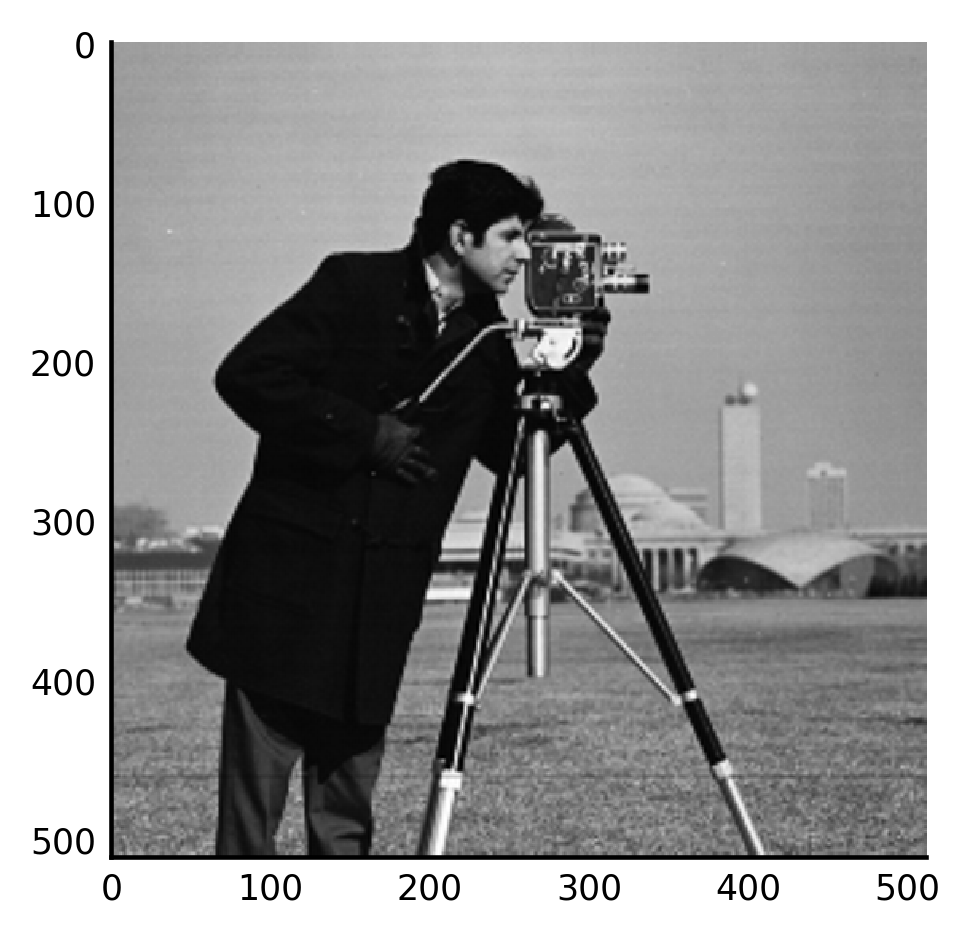

In [14]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../style/elegant.mplstyle')

from skimage import data
image = data.camera()
plt.imshow(image);

In [15]:
angle = 30
c = np.cos(np.deg2rad(angle))
s = np.sin(np.deg2rad(angle))

H = np.array([[c, -s,  0],
              [s,  c,  0],
              [0,  0,  1]])

In [16]:
point = np.array([1, 0, 1])
print(np.sqrt(3) / 2)
print(H @ point)

0.8660254037844386
[0.8660254 0.5       1.       ]


In [17]:
print(H @ H @ H @ point)

[2.77555756e-16 1.00000000e+00 1.00000000e+00]


In [18]:
from itertools import product

def homography(tf, image_shape):
    """Represent homographic transformation & interpolation as linear operator.

    Parameters
    ----------
    tf : (3, 3) ndarray
        Transformation matrix.
    image_shape : (M, N)
        Shape of input gray image.

    Returns
    -------
    A : (M * N, M * N) sparse matrix
        Linear-operator representing transformation + bilinear interpolation.

    """
    # Invert matrix.  This tells us, for each output pixel, where to
    # find its corresponding input pixel.
    H = np.linalg.inv(tf)

    m, n = image_shape

    # We are going to construct a COO matrix, often called IJK matrix,
    # for which we'll need row coordinates (I), column coordinates (J),
    # and values (K).
    row, col, values = [], [], []

    # For each pixel in the output image...
    for sparse_op_row, (out_row, out_col) in \
            enumerate(product(range(m), range(n))):

        # Compute where it came from in the input image
        in_row, in_col, in_abs = H @ [out_row, out_col, 1]
        in_row /= in_abs
        in_col /= in_abs

        # if the coordinates are outside of the original image, ignore this
        # coordinate; we will have 0 at this position
        if (not 0 <= in_row < m - 1 or
                not 0 <= in_col < n - 1):
            continue

        # We want to find the four surrounding pixels, so that we
        # can interpolate their values to find an accurate
        # estimation of the output pixel value.
        # We start with the top, left corner, noting that the remaining
        # points are 1 away in each direction.
        top = int(np.floor(in_row))
        left = int(np.floor(in_col))

        # Calculate the position of the output pixel, mapped into
        # the input image, within the four selected pixels.
        # https://commons.wikimedia.org/wiki/File:BilinearInterpolation.svg
        t = in_row - top
        u = in_col - left

        # The current row of the sparse operator matrix is given by the
        # raveled output pixel coordinates, contained in sparse_op_row.
        # We will take the weighted average of the four surrounding input
        # pixels, corresponding to four columns. So we need to repeat the row
        # index four times.
        row.extend([sparse_op_row] * 4)

        # The actual weights are calculated according to the bilinear
        # interpolation algorithm, as shown at
        # https://en.wikipedia.org/wiki/Bilinear_interpolation
        sparse_op_col = np.ravel_multi_index(
                ([top,  top,      top + 1, top + 1 ],
                 [left, left + 1, left,    left + 1]), dims=(m, n))
        col.extend(sparse_op_col)
        values.extend([(1-t) * (1-u), (1-t) * u, t * (1-u), t * u])

    operator = sparse.coo_matrix((values, (row, col)),
                                 shape=(m*n, m*n)).tocsr()
    return operator

In [19]:
def apply_transform(image, tf):
    return (tf @ image.flat).reshape(image.shape)

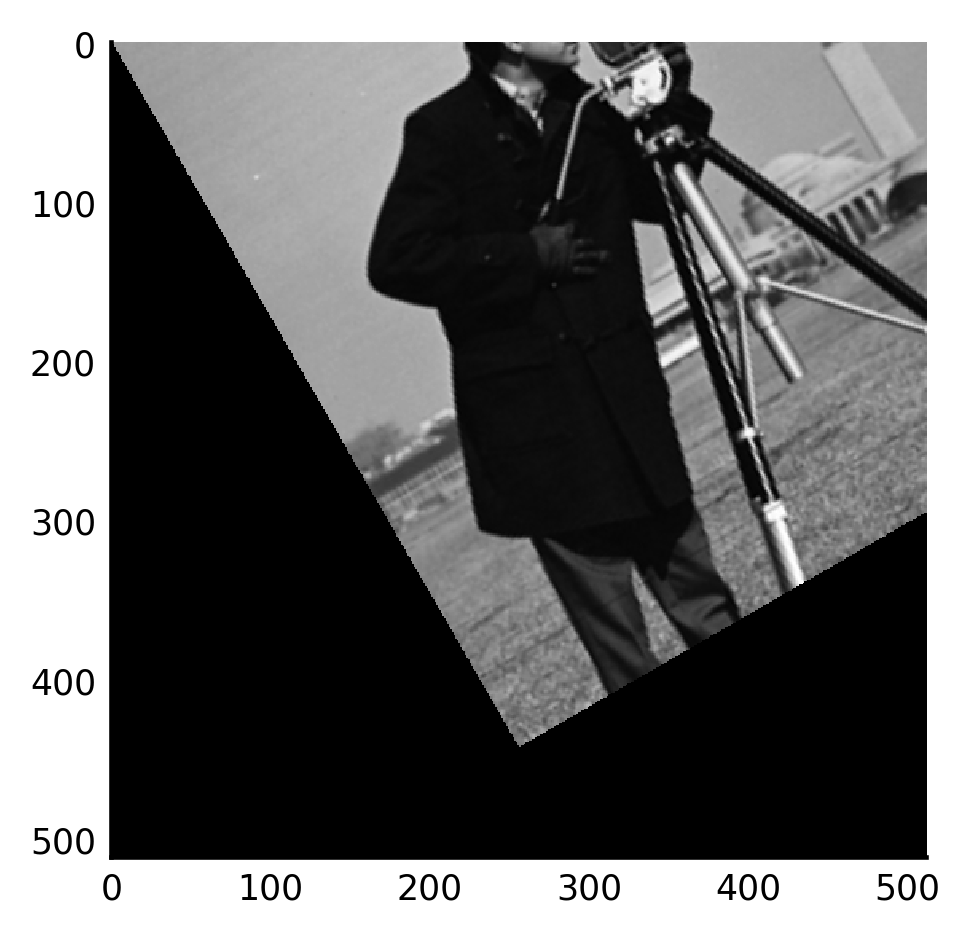

In [20]:
tf = homography(H, image.shape)
out = apply_transform(image, tf)
plt.imshow(out);

In [21]:
%timeit apply_transform(image, tf)

987 µs ± 29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
from scipy import ndimage as ndi
%timeit ndi.rotate(image, 30, reshape=False, order=1)

8.97 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
row = [0, 0, 2]
col = [1, 1, 2]
dat = [5, 7, 1]
S = sparse.coo_matrix((dat, (row, col)))

In [24]:
print(S.toarray())

[[ 0 12  0]
 [ 0  0  0]
 [ 0  0  1]]


In [25]:
from scipy import sparse

def confusion_matrix(pred, gt):
    cont = sparse.coo_matrix((np.ones(pred.size), (pred, gt)))
    return cont

In [26]:
cont = confusion_matrix(pred, gt)
print(cont)

  (0, 0)	1.0
  (1, 0)	1.0
  (0, 0)	1.0
  (0, 0)	1.0
  (1, 0)	1.0
  (1, 1)	1.0
  (1, 1)	1.0
  (0, 1)	1.0
  (1, 1)	1.0
  (1, 1)	1.0


In [27]:
print(cont.toarray())

[[3. 1.]
 [2. 4.]]


In [28]:
seg = np.array([[1, 1, 2],
                [1, 2, 2],
                [3, 3, 3]], dtype=int)

In [29]:
gt = np.array([[1, 1, 1],
               [1, 1, 1],
               [2, 2, 2]], dtype=int)

In [30]:
print(seg.ravel())
print(gt.ravel())

[1 1 2 1 2 2 3 3 3]
[1 1 1 1 1 1 2 2 2]


In [31]:
cont = sparse.coo_matrix((np.ones(seg.size),
                          (seg.ravel(), gt.ravel())))
print(cont)

  (1, 1)	1.0
  (1, 1)	1.0
  (2, 1)	1.0
  (1, 1)	1.0
  (2, 1)	1.0
  (2, 1)	1.0
  (3, 2)	1.0
  (3, 2)	1.0
  (3, 2)	1.0


In [32]:
prains = np.array([25, 27, 24, 18, 14, 11, 7, 8, 10, 15, 18, 23]) / 100
pshine = 1 - prains
p_rain_g_month = np.column_stack([prains, pshine])
# replace 'None' below with expression for nonconditional contingency
# table. Hint: the values in the table must sum to 1.
p_rain_month = None
# Add your code below to compute H(M|R) and H(M)

In [33]:
S = np.array([[0, 1],
              [2, 3]], int)

T = np.array([[0, 1],
              [0, 1]], int)

In [34]:
S.ravel()

array([0, 1, 2, 3])

In [35]:
cont = sparse.coo_matrix((np.broadcast_to(1., S.size),
                          (S.ravel(), T.ravel())))
cont = cont.toarray()
cont

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [36]:
cont /= np.sum(cont)

In [37]:
p_S = np.sum(cont, axis=1)
p_T = np.sum(cont, axis=0)

In [38]:
print('The log of 0 is: ', np.log2(0))
print('0 times the log of 0 is: ', 0 * np.log2(0))

The log of 0 is:  -inf
0 times the log of 0 is:  nan


<ipython-input-38-23db40a4a6af>:1: RuntimeWarning: divide by zero encountered in log2
  print('The log of 0 is: ', np.log2(0))
<ipython-input-38-23db40a4a6af>:2: RuntimeWarning: divide by zero encountered in log2
  print('0 times the log of 0 is: ', 0 * np.log2(0))
<ipython-input-38-23db40a4a6af>:2: RuntimeWarning: invalid value encountered in double_scalars
  print('0 times the log of 0 is: ', 0 * np.log2(0))


In [39]:
def xlog1x(arr_or_mat):
    """Compute the element-wise entropy function of an array or matrix.

    Parameters
    ----------
    arr_or_mat : numpy array or scipy sparse matrix
        The input array of probabilities. Only sparse matrix formats with a
        `data` attribute are supported.

    Returns
    -------
    out : array or sparse matrix, same type as input
        The resulting array. Zero entries in the input remain as zero,
        all other entries are multiplied by the log (base 2) of their
        inverse.
    """
    out = arr_or_mat.copy()
    if isinstance(out, sparse.spmatrix):
        arr = out.data
    else:
        arr = out
    nz = np.nonzero(arr)
    arr[nz] *= -np.log2(arr[nz])
    return out

In [40]:
a = np.array([0.25, 0.25, 0, 0.25, 0.25])
xlog1x(a)

array([0.5, 0.5, 0. , 0.5, 0.5])

In [41]:
mat = sparse.csr_matrix([[0.125, 0.125, 0.25,    0],
                         [0.125, 0.125,    0, 0.25]])
xlog1x(mat).A

array([[0.375, 0.375, 0.5  , 0.   ],
       [0.375, 0.375, 0.   , 0.5  ]])

In [42]:
H_ST = np.sum(np.sum(xlog1x(cont / p_T), axis=0) * p_T)
H_ST

1.0

In [43]:
H_TS = np.sum(np.sum(xlog1x(cont / p_S[:, np.newaxis]), axis=1) * p_S)
H_TS

0.0

In [44]:
import numpy as np
from scipy import sparse


def invert_nonzero(arr):
    arr_inv = arr.copy()
    nz = np.nonzero(arr)
    arr_inv[nz] = 1 / arr[nz]
    return arr_inv


def variation_of_information(x, y):
    # compute contingency matrix, aka joint probability matrix
    n = x.size
    Pxy = sparse.coo_matrix((np.full(n, 1/n), (x.ravel(), y.ravel())),
                            dtype=float).tocsr()

    # compute marginal probabilities, converting to 1D array
    px = np.ravel(Pxy.sum(axis=1))
    py = np.ravel(Pxy.sum(axis=0))

    # use sparse matrix linear algebra to compute VI
    # first, compute the inverse diagonal matrices
    Px_inv = sparse.diags(invert_nonzero(px))
    Py_inv = sparse.diags(invert_nonzero(py))

    # then, compute the entropies
    hygx = px @ xlog1x(Px_inv @ Pxy).sum(axis=1)
    hxgy = xlog1x(Pxy @ Py_inv).sum(axis=0) @ py

    # return the sum of these
    return float(hygx + hxgy)

In [45]:
variation_of_information(S, T)

1.0

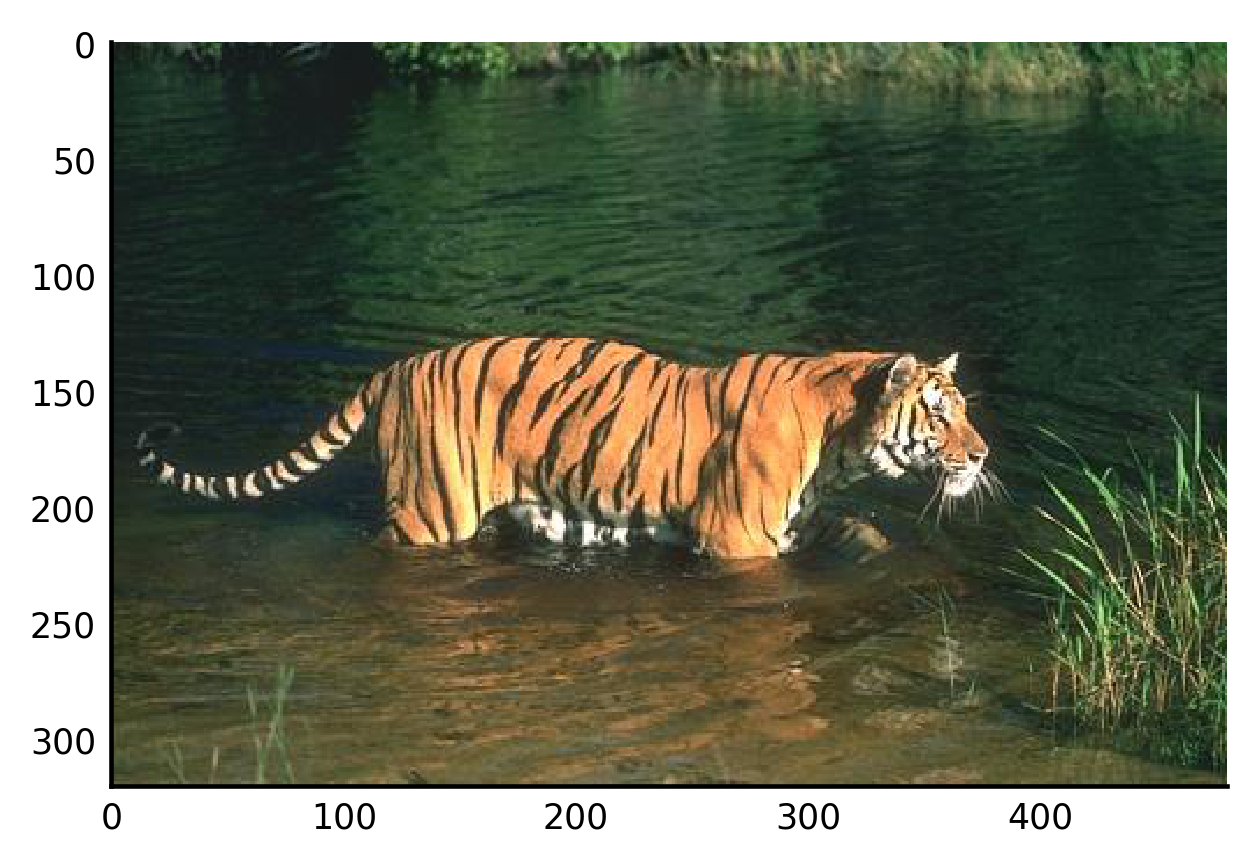

In [46]:
from skimage import io

url = ('http://www.eecs.berkeley.edu/Research/Projects/CS/vision/bsds'
       '/BSDS300/html/images/plain/normal/color/108073.jpg')
tiger = io.imread(url)

plt.imshow(tiger);

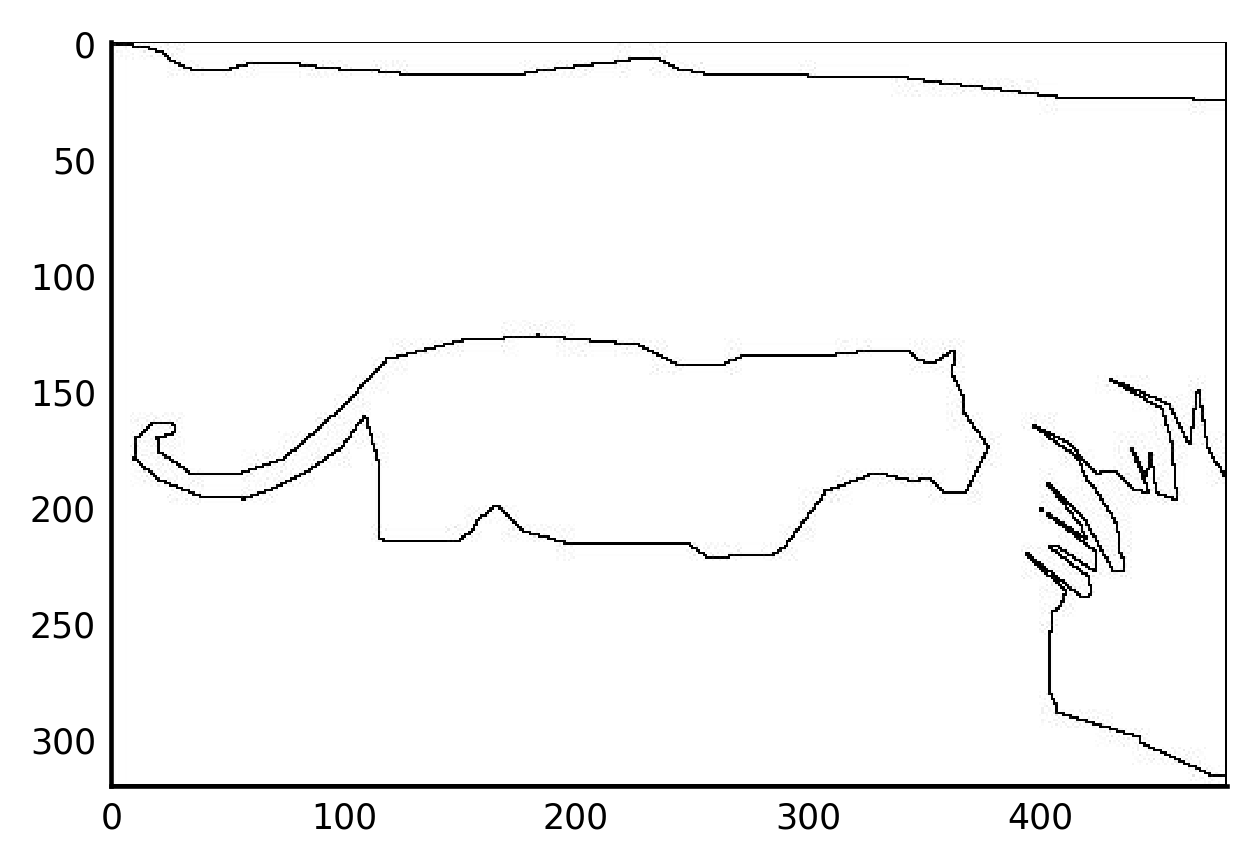

In [47]:
from scipy import ndimage as ndi
from skimage import color

human_seg_url = ('http://www.eecs.berkeley.edu/Research/Projects/CS/'
                 'vision/bsds/BSDS300/html/images/human/normal/'
                 'outline/color/1122/108073.jpg')
boundaries = io.imread(human_seg_url)
plt.imshow(boundaries);

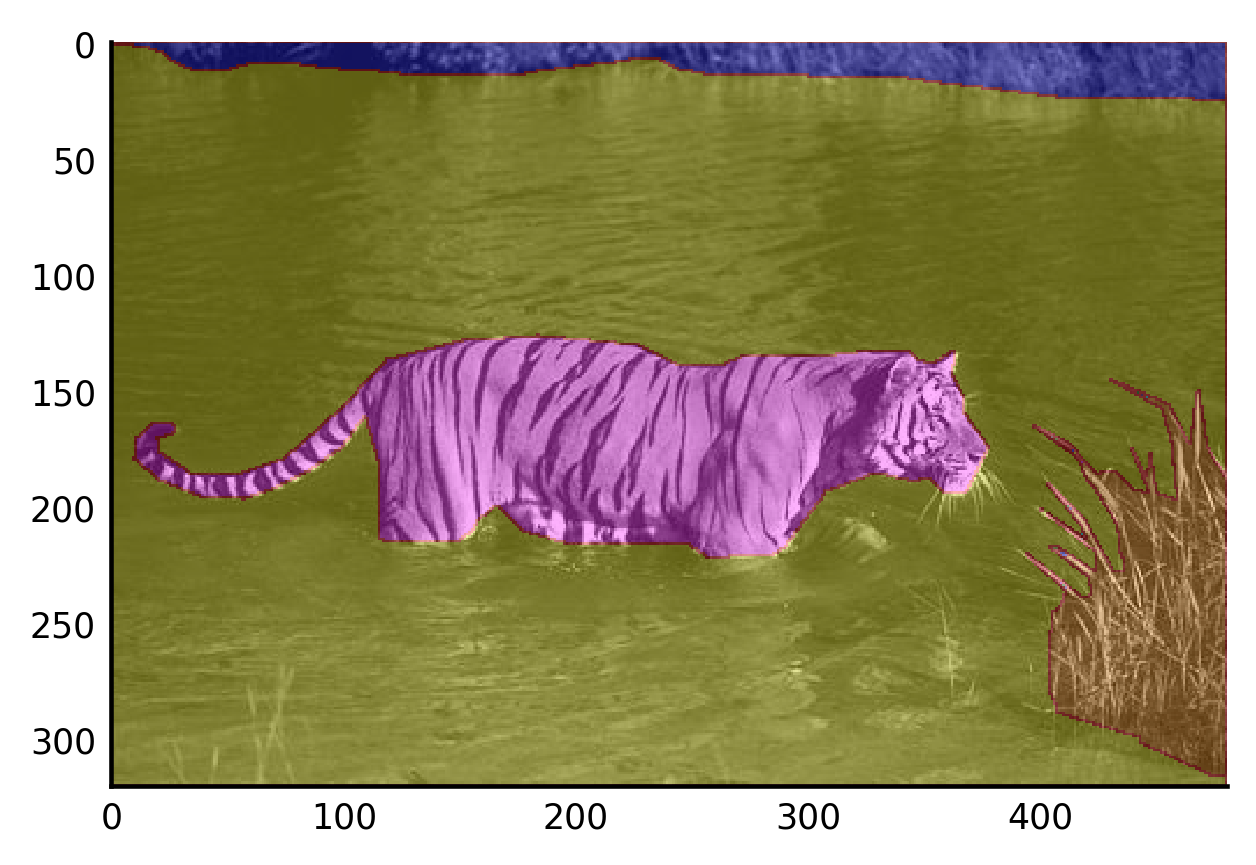

In [48]:
human_seg = ndi.label(boundaries > 100)[0]
plt.imshow(color.label2rgb(human_seg, tiger));

In [49]:
# Draw a region adjacency graph (RAG) - all code from Ch3
import networkx as nx
import numpy as np
from skimage.future import graph

def add_edge_filter(values, graph):
    current = values[0]
    neighbors = values[1:]
    for neighbor in neighbors:
        graph.add_edge(current, neighbor)
    return 0. # generic_filter requires a return value, which we ignore!

def build_rag(labels, image):
    g = nx.Graph()
    footprint = ndi.generate_binary_structure(labels.ndim, connectivity=1)
    for j in range(labels.ndim):
        fp = np.swapaxes(footprint, j, 0)
        fp[0, ...] = 0  # zero out top of footprint on each axis
    _ = ndi.generic_filter(labels, add_edge_filter, footprint=footprint,
                          mode='nearest', extra_arguments=(g,))
    for n in g:
        g.nodes[n]['total color'] = np.zeros(3, np.double)
        g.nodes[n]['pixel count'] = 0
    for index in np.ndindex(labels.shape):
        n = labels[index]
        g.nodes[n]['total color'] += image[index]
        g.nodes[n]['pixel count'] += 1
    return g

def threshold_graph(g, t):
    to_remove = [(u, v) for (u, v, d) in g.edges(data=True)
                 if d['weight'] > t]
    g.remove_edges_from(to_remove)

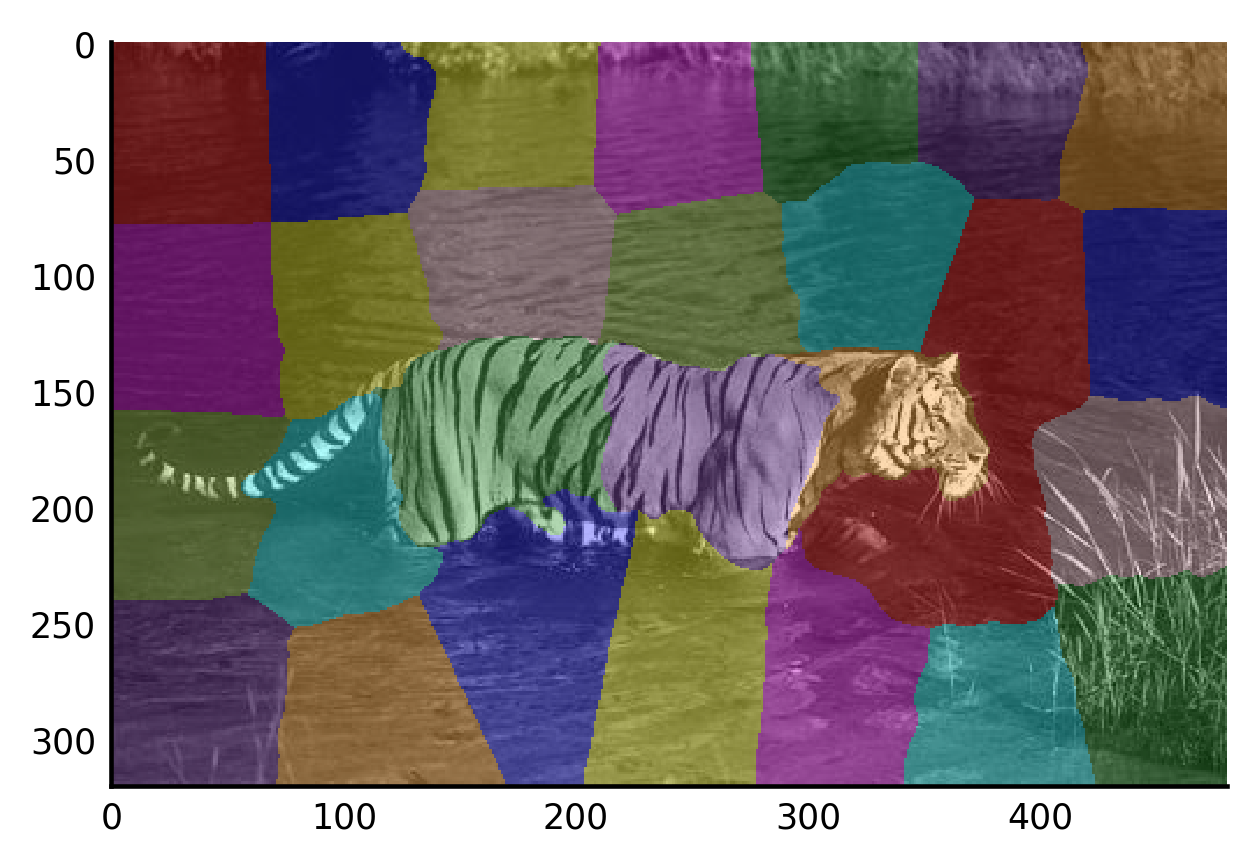

In [50]:
# Baseline segmentation
from skimage import segmentation
seg = segmentation.slic(tiger, n_segments=30, compactness=40.0,
                        enforce_connectivity=True, sigma=3)
plt.imshow(color.label2rgb(seg, tiger));

In [51]:
def rag_segmentation(base_seg, image, threshold=80):
    g = build_rag(base_seg, image)
    for n in g:
        node = g.nodes[n]
        node['mean'] = node['total color'] / node['pixel count']
    for u, v in g.edges():
        d = g.nodes[u]['mean'] - g.nodes[v]['mean']
        g[u][v]['weight'] = np.linalg.norm(d)

    threshold_graph(g, threshold)

    map_array = np.zeros(np.max(seg) + 1, int)
    for i, segment in enumerate(nx.connected_components(g)):
        for initial in segment:
            map_array[int(initial)] = i
    segmented = map_array[seg]
    return(segmented)

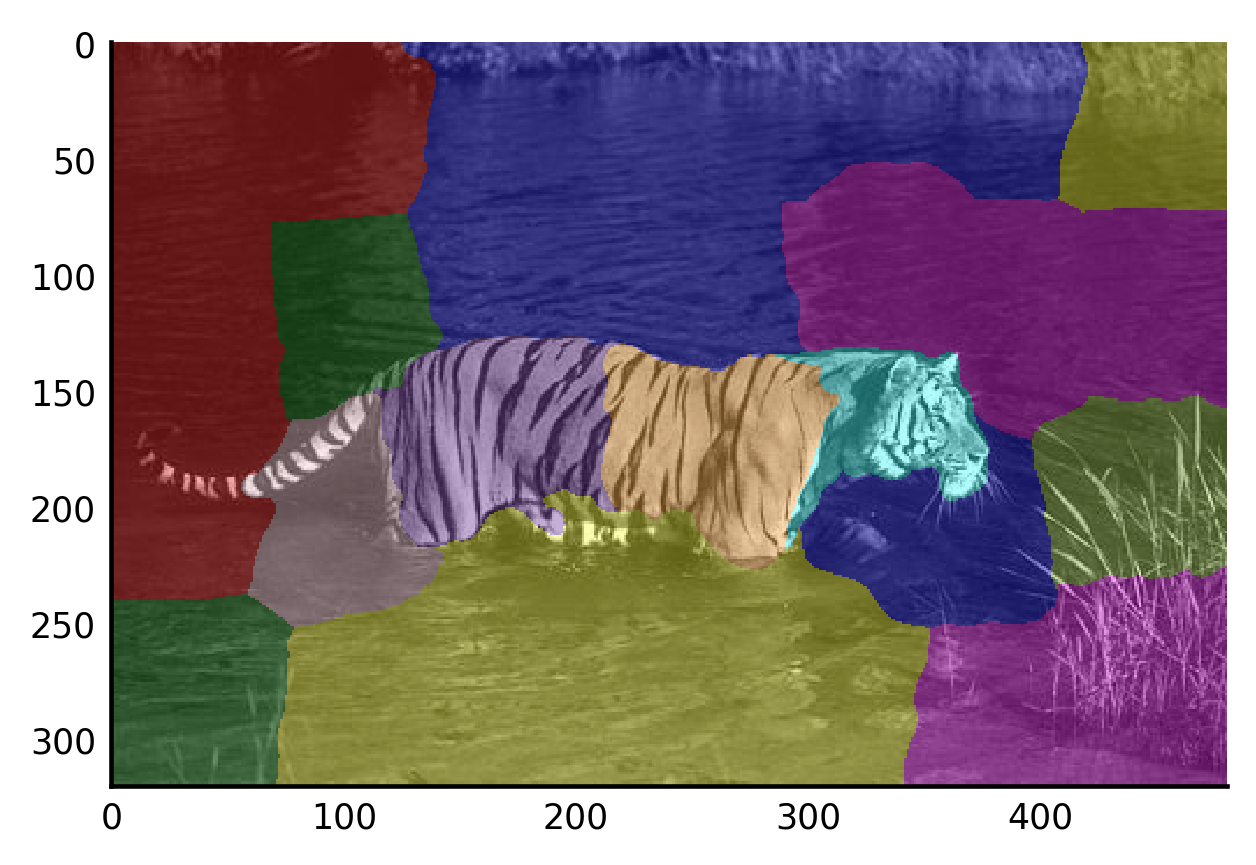

In [52]:
auto_seg_10 = rag_segmentation(seg, tiger, threshold=10)
plt.imshow(color.label2rgb(auto_seg_10, tiger));

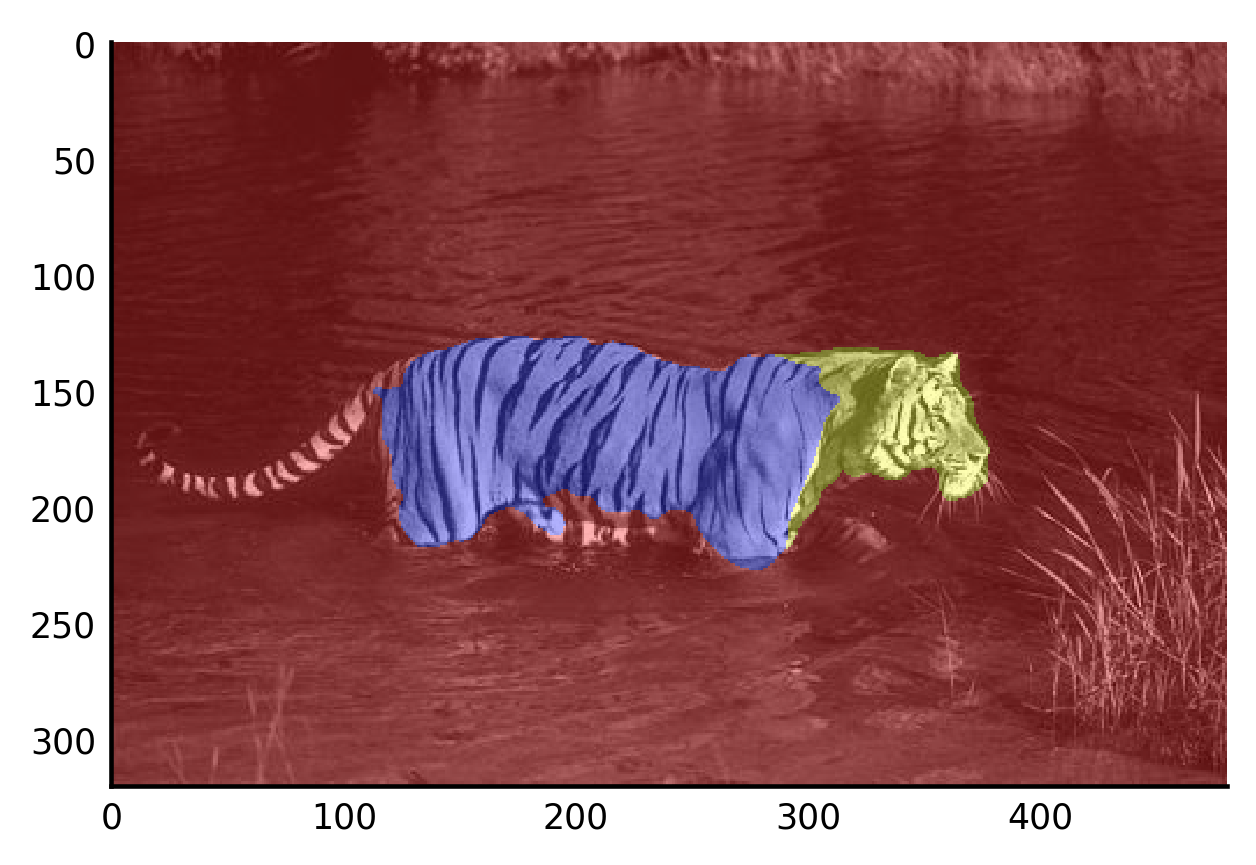

In [53]:
auto_seg_40 = rag_segmentation(seg, tiger, threshold=40)
plt.imshow(color.label2rgb(auto_seg_40, tiger));

In [54]:
variation_of_information(auto_seg_10, human_seg)

3.448846078748467

In [55]:
variation_of_information(auto_seg_40, human_seg)

1.0381218706894477

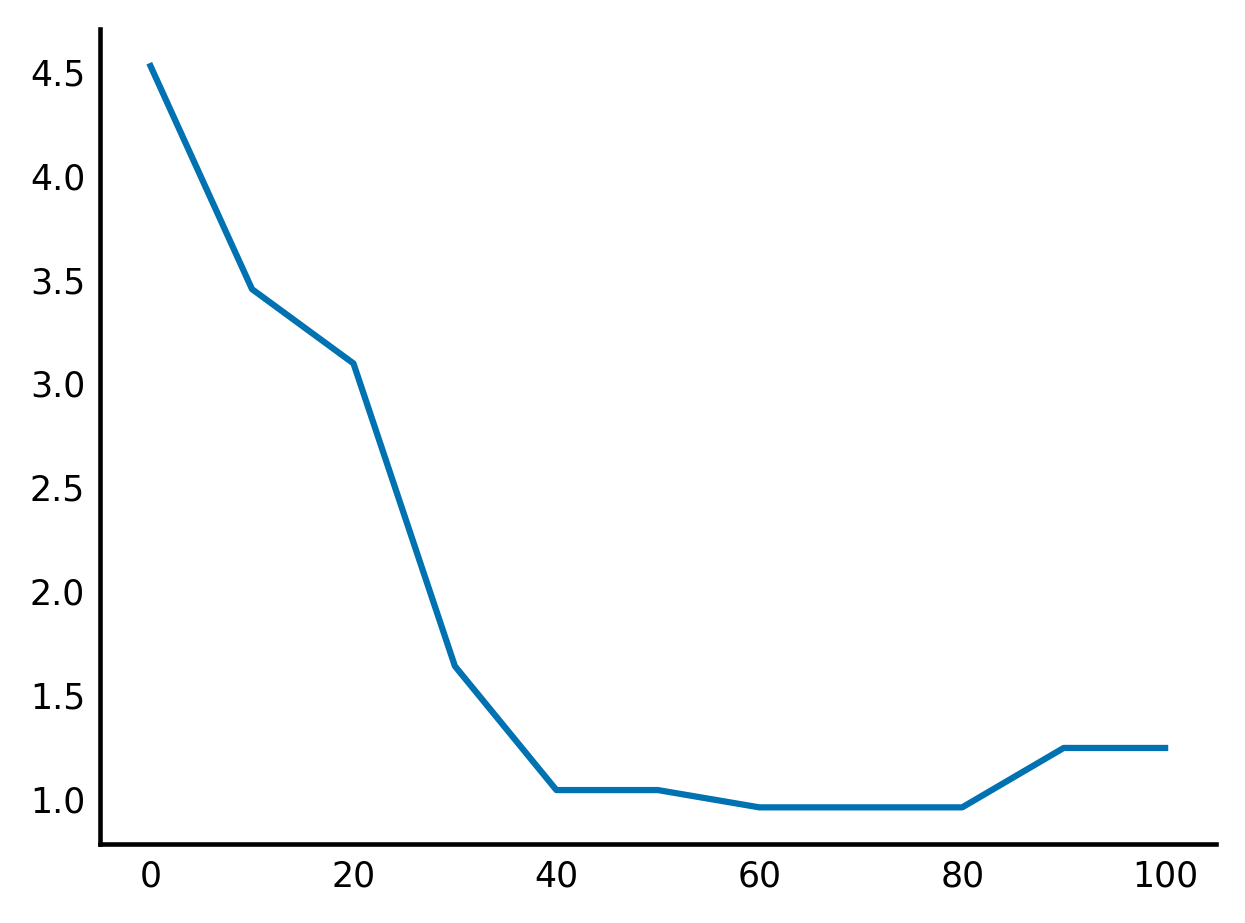

In [56]:
# Try many thresholds
def vi_at_threshold(seg, tiger, human_seg, threshold):
    auto_seg = rag_segmentation(seg, tiger, threshold)
    return variation_of_information(auto_seg, human_seg)

thresholds = range(0, 110, 10)
vi_per_threshold = [vi_at_threshold(seg, tiger, human_seg, threshold)
                    for threshold in thresholds]

plt.plot(thresholds, vi_per_threshold);

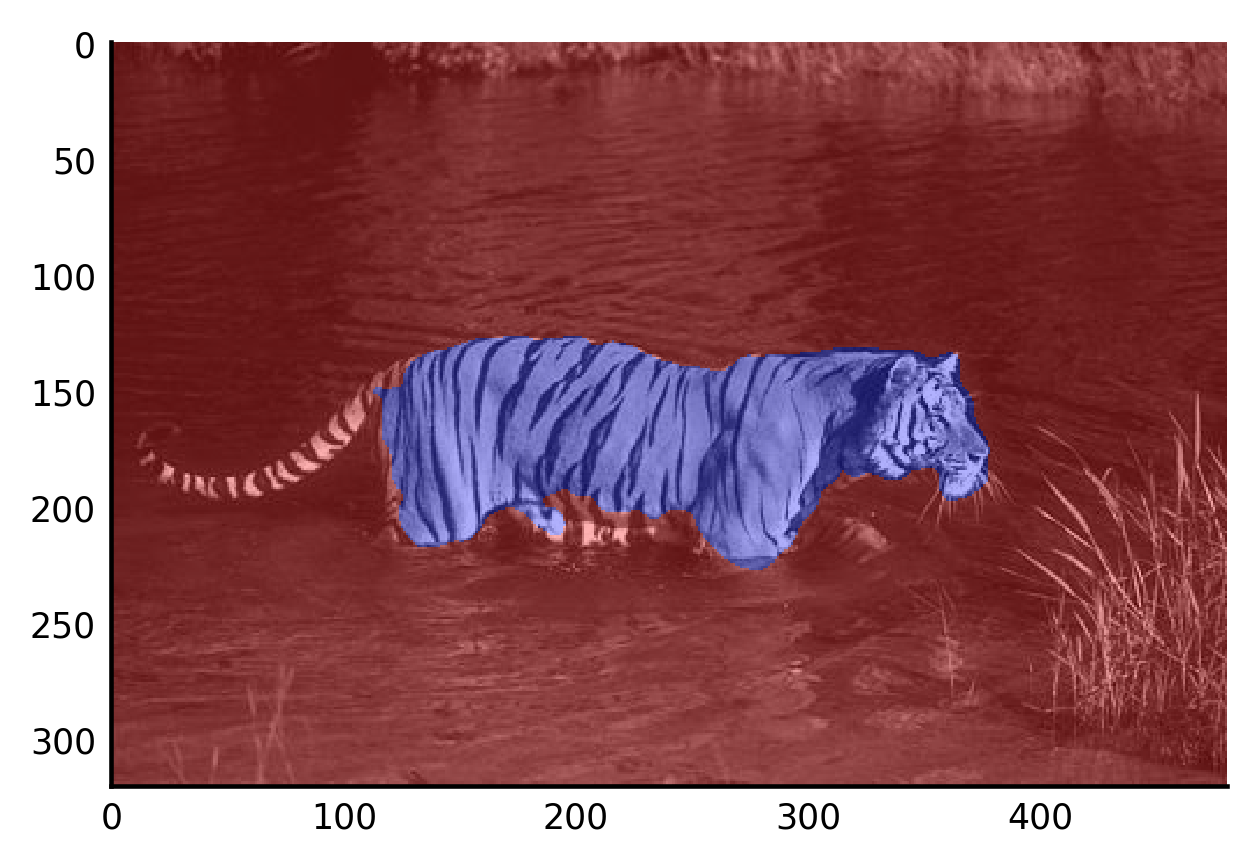

In [57]:
auto_seg = rag_segmentation(seg, tiger, threshold=80)
plt.imshow(color.label2rgb(auto_seg, tiger));
